<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Imports and Scripts

In [3]:
%%javascript
// ToC script
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [4]:
# Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')



In [1]:
# imports and constants
import json
import pickle
import datetime as dt

import gmaps
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import multiprocessing
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns

from IPython.display import display, HTML
import ipywidgets as widgets

# user imports
import data_processing.analysis_utils as ls_utils

%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

,baseline_cluster,cluster,diff,gad01,gad02,gad03,gad04,gad05,gad06,gad07,...,entropy_wkend,loc_var_total,loc_var_wkday,loc_var_wkend,norm_entropy_total,norm_entropy_wkday,norm_entropy_wkend,velocity_total,velocity_wkday,velocity_wkend
0,dep_anx,dep_anx,NaT,3.0,3.0,3.0,3.0,3.0,3.0,2.0,...,0.126300,-3.758927,-3.494088,-6.734655,0.172164,0.196291,0.114963,4.403619,5.896776,1.040765
1,dep_anx,dep_anx,21 days 20:34:41,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.805508,-1.785284,-4.420466,-0.527020,0.180287,0.152578,0.260594,6.999583,4.347594,13.629558
2,dep_anx,dep_anx,20 days 00:45:49,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,0.549133,-4.591384,-4.414591,-5.370500,0.198368,0.211625,0.214091,5.126712,4.901078,5.647615
3,dep_anx,dep_anx,21 days 06:12:55,3.0,2.0,2.0,2.0,2.0,3.0,3.0,...,0.642235,-3.616418,-4.349368,-3.050339,0.221663,0.197513,0.278919,4.690188,4.792503,4.439534
4,dep_anx,dep_anx,20 days 12:00:43,1.0,2.0,2.0,3.0,2.0,3.0,2.0,...,0.851023,-3.288352,-3.095763,-4.142046,0.206789,0.178505,0.294434,7.050477,7.132282,6.853812


,pid,study_wk,fga_factor1_agg,fga_factor2_agg,fga_factor3_agg,fga_factor4_agg,fga_factor5_agg
0,00746649,4.0,2.460662,0.570217,-0.764438,0.238423,0.422445
1,00746649,7.0,1.931026,1.080773,-1.217253,0.885970,0.883004
2,00746649,10.0,1.473713,1.085189,-0.945762,1.261351,0.583782
3,00746649,13.0,1.358061,1.609506,-1.306715,0.709605,0.619392
4,00746649,16.0,2.060474,1.361615,-1.025838,0.781939,0.510771


(976, 7)


<Figure size 640x480 with 2 Axes>

,pid,study_wk,fga_factor1_agg,fga_factor2_agg,fga_factor3_agg,fga_factor4_agg,fga_factor5_agg
971,99338619,4.0,-0.278616,-0.374250,0.051163,-0.183525,-0.040398
972,99338619,7.0,-0.160015,-0.326489,0.131822,0.055936,-0.279439
973,99338619,10.0,-0.215069,-0.373783,0.076851,-0.072024,-0.170123
974,99338619,13.0,-0.250782,-0.380933,-0.046691,-0.155999,-0.090260
975,99338619,16.0,-0.269152,-0.339850,-0.085117,-0.191245,-0.056511


# Load Data

In [2]:
spin_fill_df = pd.read_pickle("ls_data/state_cluster_shift.df")
shift_df = pd.read_pickle("ls_data/phq_cluster_shift.df")

**note**: sourced originally from lifesense_cluster_change_over_time, under "Correlates Over Time" heading

In [3]:
# build cal_daily
all_cal = pd.read_pickle("wave1_features/cal_hr.df")
all_cal['date'] = all_cal['hour'].dt.floor('d')
cal_daily = all_cal.groupby(['pid', 'date']).sum()
cal_daily = cal_daily.reset_index()
cal_daily["is_wkday"] = (pd.to_datetime(cal_daily['date']).dt.dayofweek < 5).astype(float)

display(cal_daily.head())

,pid,date,tot_call_count,tot_call_duration,is_wkday
0,00746649,2019-07-23,12,1814,1.0
1,00746649,2019-07-24,15,4572,1.0
2,00746649,2019-07-25,20,2363,1.0
3,00746649,2019-07-26,15,8063,1.0
4,00746649,2019-07-27,10,1748,0.0


In [4]:
# build sms_daily
all_sms = pd.read_pickle("wave1_features/sms_hr.df")
all_sms['date'] = all_sms['hour'].dt.floor('d')
sms_daily = all_sms.groupby(['pid', 'date']).sum()
sms_daily = sms_daily.reset_index()
sms_daily["is_wkday"] = (pd.to_datetime(sms_daily['date']).dt.dayofweek < 5).astype(float)

display(sms_daily.head())

,pid,date,tot_sms_count,tot_sms_length,in_sms_count,in_sms_length,out_sms_count,out_sms_length,is_wkday
0,00746649,2019-07-23,22,1738,22.0,1738.0,0.0,0.0,1.0
1,00746649,2019-07-24,24,1464,24.0,1464.0,0.0,0.0,1.0
2,00746649,2019-07-25,14,936,14.0,936.0,0.0,0.0,1.0
3,00746649,2019-07-26,23,2135,23.0,2135.0,0.0,0.0,1.0
4,00746649,2019-07-27,21,990,21.0,990.0,0.0,0.0,0.0


In [5]:
# build fga_daily
all_fga = pd.read_pickle("wave1_features/fga_hr.df")
all_fga['all_browser'] = all_fga['browser'] + all_fga['chrome']
all_fga['date'] = all_fga['hr'].dt.floor('d')
fga_daily = all_fga.groupby(['pid', 'date']).sum()
fga_daily = fga_daily.reset_index()
fga_daily["is_wkday"] = (pd.to_datetime(fga_daily['date']).dt.dayofweek < 5).astype(float)

display(fga_daily.head())

,pid,date,katana,orca,messaging,launcher,chrome,email,instagram,youtube,maps,snapchat,browser,all_browser,is_wkday
0,00746649,2019-07-23,0.0,0.0,3380.0,1753.0,1490.0,1113.0,211.0,1080.0,240.0,0.0,165.0,1655.0,1.0
1,00746649,2019-07-24,0.0,105.0,1888.0,2831.0,965.0,713.0,1203.0,0.0,0.0,0.0,931.0,1896.0,1.0
2,00746649,2019-07-25,0.0,135.0,5835.0,1826.0,98.0,770.0,368.0,0.0,73.0,0.0,509.0,607.0,1.0
3,00746649,2019-07-26,0.0,301.0,5288.0,1986.0,195.0,1362.0,842.0,0.0,1410.0,0.0,1065.0,1260.0,1.0
4,00746649,2019-07-27,0.0,0.0,3166.0,686.0,0.0,110.0,3310.0,0.0,847.0,0.0,0.0,0.0,0.0


In [6]:
%%time
# build sloc_daily
all_sloc = pd.read_pickle("wave1_features/sloc_hr.df")
all_sloc['date'] = all_sloc['hr'].dt.floor('d')

CPU times: user 279 ms, sys: 2.23 s, total: 2.51 s
Wall time: 4.31 s


In [7]:
%%time

sloc_cols = list(all_sloc.columns[all_sloc.columns.str.endswith('dur')])
all_sloc[sloc_cols] = all_sloc[sloc_cols].clip(0, 100000000)
sloc_daily = all_sloc.groupby(['pid', 'date']).sum()
sloc_daily = sloc_daily.reset_index()
sloc_daily["is_wkday"] = (pd.to_datetime(sloc_daily['date']).dt.dayofweek < 5).astype(float)

display(sloc_daily.head())

,pid,date,food_dur,home_dur,work_dur,exercise_dur,anothers_home_dur,religion_dur,travel_dur,shopping_dur,...,n/a_religion,n/a_travel,n/a_shopping,n/a_errand,n/a_health,n/a_education,n/a_entertainment,n/a_other,tot_tansitions,is_wkday
0,00746649,2019-07-23,0.0,21869.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,2,0,0,0,9,1.0
1,00746649,2019-07-24,0.0,54305.0,7379.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,1,13,1.0
2,00746649,2019-07-25,0.0,48121.0,0.0,0.0,0.0,753.0,0.0,0.0,...,1,0,0,0,1,0,1,1,10,1.0
3,00746649,2019-07-26,0.0,49696.0,0.0,3824.0,3726.0,0.0,0.0,3790.0,...,0,0,2,0,1,0,1,1,17,1.0
4,00746649,2019-07-27,0.0,28339.0,0.0,536.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,6,0.0


CPU times: user 1.18 s, sys: 3.34 s, total: 4.52 s
Wall time: 4.53 s


In [8]:
drop_cols = sloc_daily.columns[sloc_daily.columns.str.contains('n/a')]
sloc_daily = sloc_daily.drop(drop_cols, axis='columns')

## Build SPIN/GAD Sequence DF

In [9]:
# load fus and circ data
fus_daily = pd.read_pickle("wave1_features/fus_gad_start_14_-1.df")
circ_dict = pickle.load(open("wave1_features/circ_gad_start_14_-1.dict", "rb"))

In [10]:
# correction for Series values in list, though it doesn't seem to have affected anything??
new_dict = {}
for col, vals in circ_dict.items():
    new_vals = []
    for v in vals:
        if isinstance(v, pd.Series):
            new_vals.append(v[0])
        else:
            new_vals.append(v)
    new_dict[col] = new_vals
circ_dict = new_dict

In [11]:
# columns
sms_cols = ['tot_sms_count', 'tot_sms_length', 'in_sms_count', 'in_sms_length', 'out_sms_count', 'out_sms_length']
cal_cols = ['tot_call_count', 'tot_call_duration']
fga_cols = ['katana', 'orca', 'messaging', 'email', 'instagram', 'youtube', 'maps', 'snapchat', 'browser', 'chrome']

circ_cols = ['circ_movt_tot', 'circ_movt_wkday', 'circ_movt_wkend']
fus_cols = list(fus_daily.columns[(fus_daily.columns.str.endswith('total') | fus_daily.columns.str.endswith('wkend') | fus_daily.columns.str.endswith('wkday')) & ~fus_daily.columns.str.startswith('date')])
sloc_cols = list(sloc_daily.columns.drop(['pid', 'date', 'is_wkday']))
#sloc_cols = list(sloc_daily.columns[sloc_daily.columns.str.endswith('dur')])

### Calculate shifted change

In [12]:
spin_fill_df['date'] = spin_fill_df['spin_start'].dt.normalize()

In [13]:
spin_fill_df['spin_total_shift'] = spin_fill_df.groupby('pid')['spin_total'].shift(1)
spin_fill_df['spin_diff'] = spin_fill_df['spin_total'] - spin_fill_df['spin_total_shift']

In [14]:
spin_fill_df['gad_total_shift'] = spin_fill_df.groupby('pid')['gad_total'].shift(1)
spin_fill_df['gad_diff'] = spin_fill_df['gad_total'] - spin_fill_df['gad_total_shift']

In [15]:
%%time

sms_dict = ls_utils.build_col_dict(sms_cols, sms_daily, spin_fill_df, 'spin_start', pre_days=14, post_days=-1)
cal_dict = ls_utils.build_col_dict(cal_cols, cal_daily, spin_fill_df, 'spin_start', pre_days=14, post_days=-1)
fga_dict = ls_utils.build_col_dict(fga_cols, fga_daily, spin_fill_df, 'spin_start', pre_days=14, post_days=-1)
sloc_dict = ls_utils.build_col_dict(sloc_cols, sloc_daily, spin_fill_df, 'spin_start', pre_days=14, post_days=-1)

CPU times: user 40.4 s, sys: 0 ns, total: 40.4 s
Wall time: 40.4 s


In [16]:
dig_state_df = spin_fill_df.copy()

sensor_dicts = [sms_dict, cal_dict, fga_dict, sloc_dict, circ_dict]
sensor_cols = sms_cols + cal_cols + fga_cols + sloc_cols + circ_cols

for sensor_dict in sensor_dicts:
    for col, vals in sensor_dict.items():
        dig_state_df[col] = vals

# merge fused location       
dig_state_df = dig_state_df.merge(fus_daily, how='left', on=['pid', 'study_wk'])
dig_state_df = dig_state_df.replace([np.inf, -np.inf], np.nan)

# SPIN/GAD Feature Aggregation

In [32]:
id_cols = ['pid', 'study_wk']

## Foreground Application Aggregation

In [33]:
active_apps = ['messaging', 'email', 'maps']
passive_apps = ['chrome', 'youtube', 'browser']
social_apps = ['orca','katana', 'instagram', 'snapchat']

agg_df = dig_state_df.copy()
agg_df[fga_cols] = (agg_df[fga_cols] - agg_df[fga_cols].mean()) / agg_df[fga_cols].std()
agg_df['active_apps_agg'] = agg_df[active_apps].mean(axis=1)
agg_df['passive_apps_agg'] = agg_df[passive_apps].mean(axis=1)
agg_df['social_apps_agg'] = agg_df[social_apps].mean(axis=1)

## Semantic Location

In [31]:
sloc_dur_cols = sloc_daily.columns[sloc_daily.columns.str.endswith('dur')]
work_places = ['work_dur']
home_places = ['home_dur']
other_places = ['other_dur', 'health_dur', 'errand_dur', 'education_dur']
religion_exercise_places = ['exercise_dur', 'religion_dur']
social_places = ['food_dur', 'anothers_home_dur', 'entertainment_dur', 'shopping_dur']

In [39]:
agg_df[sloc_dur_cols] = (agg_df[sloc_dur_cols] - agg_df[sloc_dur_cols].mean()) / agg_df[sloc_dur_cols].std()
agg_df['work_dur_agg'] = agg_df[work_places]
agg_df['home_dur_agg'] = agg_df[home_places]
agg_df['religion_exercise_dur_agg'] = agg_df[religion_exercise_places].mean(axis=1)
agg_df['other_dur_agg'] = agg_df[other_places].mean(axis=1)
agg_df['social_place_dur_agg'] = agg_df[social_places].mean(axis=1)

## Communication

In [40]:
agg_df[sms_cols] = (agg_df[sms_cols] - agg_df[sms_cols].mean()) / agg_df[sms_cols].std()
agg_df[cal_cols] = (agg_df[cal_cols] - agg_df[cal_cols].mean()) / agg_df[cal_cols].std()
agg_df['sms_agg'] = agg_df[sms_cols].mean(axis=1)
agg_df['cal_agg'] = agg_df[cal_cols].mean(axis=1)

## Fused Location

In [42]:
loc_cols = circ_cols + fus_cols

['circ_movt_tot',
 'circ_movt_wkday',
 'circ_movt_wkend',
 'cluster_total',
 'cluster_wkday',
 'cluster_wkend',
 'dist_total',
 'dist_wkday',
 'dist_wkend',
 'entropy_total',
 'entropy_wkday',
 'entropy_wkend',
 'loc_var_total',
 'loc_var_wkday',
 'loc_var_wkend',
 'norm_entropy_total',
 'norm_entropy_wkday',
 'norm_entropy_wkend',
 'velocity_total',
 'velocity_wkday',
 'velocity_wkend']

In [43]:
movt_cols = ['circ_movt_tot',
 'circ_movt_wkday',
 'circ_movt_wkend',
 'cluster_total',
 'cluster_wkday',
 'cluster_wkend',
 'dist_total',
 'dist_wkday',
 'dist_wkend',
 'loc_var_total',
 'loc_var_wkday',
 'loc_var_wkend',

 'velocity_total',
 'velocity_wkday',
 'velocity_wkend']

weekday_entropy = [
 'norm_entropy_total',
 'norm_entropy_wkday',
 'entropy_total',
 'entropy_wkday'
]

weekend_entropy = [
'norm_entropy_wkend',
'entropy_wkend'    
]

In [44]:
agg_df[loc_cols] = (agg_df[loc_cols] - agg_df[loc_cols].mean()) / agg_df[loc_cols].std()
agg_df['movt_agg'] = agg_df[movt_cols].mean(axis=1)
agg_df['wkday_total_entropy_agg'] = agg_df[weekday_entropy].mean(axis=1)
agg_df['wkend_entropy_agg'] = agg_df[weekend_entropy].mean(axis=1)

## Shift columns

In [45]:
agg_cols = agg_df.columns[agg_df.columns.str.endswith("agg")]
agg_cols_shift = [s + '_shift' for s in agg_cols]
agg_cols_change = [s + '_change' for s in agg_cols]

In [46]:
agg_df[agg_cols_shift] = agg_df.groupby('pid')[agg_cols].shift(1)

In [47]:
for cur, prev, change in zip(agg_cols, agg_cols_shift, agg_cols_change):
    agg_df[change] = agg_df[cur] - agg_df[prev]

In [48]:
agg_df['gad_diff'].describe()

count    772.000000
mean      -0.107513
std        3.695631
min      -14.000000
25%       -2.000000
50%        0.000000
75%        2.000000
max       15.000000
Name: gad_diff, dtype: float64

In [49]:
agg_df['spin_diff'].describe()

count    771.000000
mean      -0.155642
std        6.563112
min      -30.000000
25%       -3.000000
50%        0.000000
75%        3.000000
max       36.000000
Name: spin_diff, dtype: float64

# SPIN

### Simple Correlation

#### Full population

In [50]:
print("Pearson")
pair_corr_df = pg.pairwise_corr(agg_df, columns=[agg_cols_change, ['spin_diff']], padjust="fdr_bh")
display(pair_corr_df[pair_corr_df['p-corr'] < 0.1].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])
print("Spearman")
pair_corr_df = pg.pairwise_corr(agg_df, columns=[agg_cols_change, ['spin_diff']], method='spearman', padjust="fdr_bh")
display(pair_corr_df[pair_corr_df['p-corr'] < 0.1].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

Pearson


,X,Y,n,r,p-corr,p-adjust
7,social_place_dur_agg_change,spin_diff,763,-0.117,0.015945,fdr_bh
1,passive_apps_agg_change,spin_diff,767,0.104,0.024538,fdr_bh


Spearman


,X,Y,n,r,p-corr,p-adjust
1,passive_apps_agg_change,spin_diff,767,0.115,0.01872,fdr_bh


#### no_symp

In [51]:
sel_state_df = agg_df[agg_df['baseline_cluster'] == 'no_symp']
print("Pearson")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['spin_diff']], nan_policy='pairwise', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

print("Spearman")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['spin_diff']], nan_policy='pairwise', method='spearman', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

Pearson


,X,Y,n,r,p-corr,p-adjust


Spearman


,X,Y,n,r,p-corr,p-adjust


#### soc_anx

In [52]:
sel_state_df = agg_df[agg_df['baseline_cluster'] == 'soc_anx']

print("Pearson")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['spin_diff']], nan_policy='pairwise', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

print("Spearman")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['spin_diff']], nan_policy='pairwise', method='spearman', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

Pearson


,X,Y,n,r,p-corr,p-adjust
7,social_place_dur_agg_change,spin_diff,202,-0.263,0.002047,fdr_bh
1,passive_apps_agg_change,spin_diff,202,0.224,0.008988,fdr_bh


Spearman


,X,Y,n,r,p-corr,p-adjust
1,passive_apps_agg_change,spin_diff,202,0.195,0.070704,fdr_bh
6,other_dur_agg_change,spin_diff,202,0.174,0.086603,fdr_bh


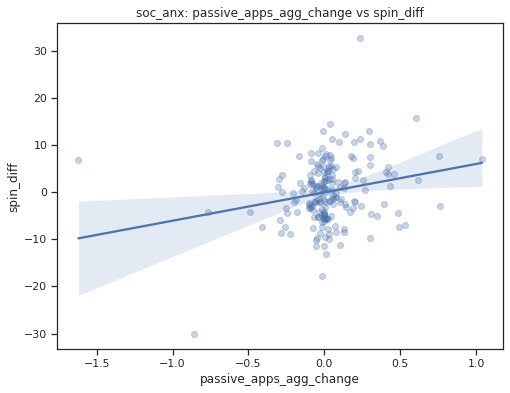

In [53]:
ls_utils.plot_cluster_scatter('passive_apps_agg_change', 'spin_diff', sel_state_df, 'soc_anx', (8,6))

#### gen_anx

In [54]:
sel_state_df = agg_df[agg_df['baseline_cluster'] == 'gen_anx']
print("Pearson")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['spin_diff']], nan_policy='pairwise', method='pearson', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

print("Spearman")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['spin_diff']], method='spearman', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

Pearson


,X,Y,n,r,p-corr,p-adjust


Spearman


,X,Y,n,r,p-corr,p-adjust


#### dep_anx

In [56]:
sel_state_df = agg_df[agg_df['baseline_cluster'] == 'dep_anx']
print("Pearson")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['spin_diff']], nan_policy='pairwise', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

print("Spearman")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['spin_diff']], method='spearman', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr'))

Pearson


,X,Y,n,r,p-corr,p-adjust


Spearman


,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,p-corr,p-adjust,power


# GAD

### Simple Correlation

#### Full population

In [57]:
print("Pearson")
pair_corr_df = pg.pairwise_corr(agg_df, columns=[agg_cols_change, ['gad_diff']], padjust="fdr_bh")
display(pair_corr_df[pair_corr_df['p-corr'] < 0.1].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])
print("Spearman")
pair_corr_df = pg.pairwise_corr(agg_df, columns=[agg_cols_change, ['gad_diff']], method='spearman', padjust="fdr_bh")
display(pair_corr_df[pair_corr_df['p-corr'] < 0.1].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

Pearson


,X,Y,n,r,p-corr,p-adjust


Spearman


,X,Y,n,r,p-corr,p-adjust
9,cal_agg_change,gad_diff,758,0.114,0.022510,fdr_bh
0,active_apps_agg_change,gad_diff,768,0.100,0.034962,fdr_bh
8,sms_agg_change,gad_diff,745,0.081,0.086909,fdr_bh
12,wkend_entropy_agg_change,gad_diff,719,-0.083,0.086909,fdr_bh


#### no_symp

In [58]:
sel_state_df = agg_df[agg_df['baseline_cluster'] == 'no_symp']
print("Pearson")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['gad_diff']], nan_policy='pairwise', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

print("Spearman")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['gad_diff']], nan_policy='pairwise', method='spearman', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

Pearson


,X,Y,n,r,p-corr,p-adjust


Spearman


,X,Y,n,r,p-corr,p-adjust


#### soc_anx

In [59]:
sel_state_df = agg_df[agg_df['baseline_cluster'] == 'soc_anx']

print("Pearson")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['gad_diff']], nan_policy='pairwise', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

print("Spearman")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['gad_diff']], nan_policy='pairwise', method='spearman', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

Pearson


,X,Y,n,r,p-corr,p-adjust


Spearman


,X,Y,n,r,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,202,0.199,0.058627,fdr_bh


#### gen_anx

In [60]:
sel_state_df = agg_df[agg_df['baseline_cluster'] == 'gen_anx']
print("Pearson")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['gad_diff']], nan_policy='pairwise', method='pearson', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

print("Spearman")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['gad_diff']], method='spearman', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

Pearson


,X,Y,n,r,p-corr,p-adjust


Spearman


,X,Y,n,r,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,176,0.24,0.017024,fdr_bh


#### dep_anx

In [61]:
sel_state_df = agg_df[agg_df['baseline_cluster'] == 'dep_anx']
print("Pearson")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['gad_diff']], nan_policy='pairwise', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

print("Spearman")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['gad_diff']], method='spearman', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

Pearson


,X,Y,n,r,p-corr,p-adjust


Spearman


,X,Y,n,r,p-corr,p-adjust
2,social_apps_agg_change,gad_diff,138,-0.259,0.028261,fdr_bh


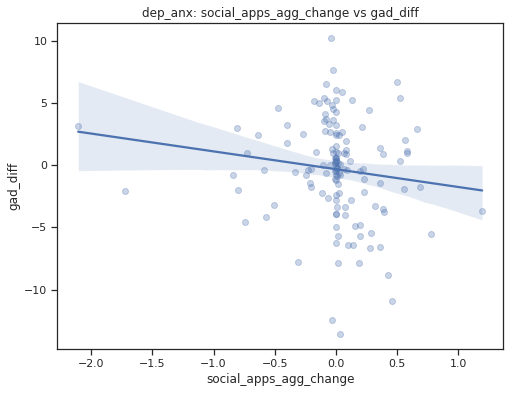

In [62]:
ls_utils.plot_cluster_scatter('social_apps_agg_change', 'gad_diff', agg_df, 'dep_anx', (8,6))

# Reverse SPIN/GAD

## Build reversed df

In [84]:
# load fus and circ data
rev_fus_daily = pd.read_pickle("wave1_features/fus_gad_start_0_14.df")
rev_circ_dict = pickle.load(open("wave1_features/circ_gad_start_0_14.dict", "rb"))

In [85]:
# correction for Series values in list, though it doesn't seem to have affected anything??
rev_new_dict = {}
for col, vals in rev_circ_dict.items():
    new_vals = []
    for v in vals:
        if isinstance(v, pd.Series):
            new_vals.append(v[0])
        else:
            new_vals.append(v)
    rev_new_dict[col] = new_vals
rev_circ_dict = rev_new_dict

### Calculate shifted change

In [86]:
spin_fill_df['date'] = spin_fill_df['spin_start'].dt.normalize()

In [87]:
spin_fill_df['spin_total_shift'] = spin_fill_df.groupby('pid')['spin_total'].shift(1)
spin_fill_df['spin_diff'] = spin_fill_df['spin_total'] - spin_fill_df['spin_total_shift']

In [88]:
spin_fill_df['gad_total_shift'] = spin_fill_df.groupby('pid')['gad_total'].shift(1)
spin_fill_df['gad_diff'] = spin_fill_df['gad_total'] - spin_fill_df['gad_total_shift']

In [89]:
%%time

sms_dict = ls_utils.build_col_dict(sms_cols, sms_daily, spin_fill_df, 'spin_start', pre_days=0, post_days=14)
cal_dict = ls_utils.build_col_dict(cal_cols, cal_daily, spin_fill_df, 'spin_start', pre_days=0, post_days=14)
fga_dict = ls_utils.build_col_dict(fga_cols, fga_daily, spin_fill_df, 'spin_start', pre_days=0, post_days=14)
sloc_dict = ls_utils.build_col_dict(sloc_cols, sloc_daily, spin_fill_df, 'spin_start', pre_days=0, post_days=14)

CPU times: user 58.8 s, sys: 193 ms, total: 59 s
Wall time: 1min


In [90]:
rev_dig_state_df = spin_fill_df.copy()

sensor_dicts = [sms_dict, cal_dict, fga_dict, sloc_dict, rev_circ_dict]
sensor_cols = sms_cols + cal_cols + fga_cols + sloc_cols + circ_cols

for sensor_dict in sensor_dicts:
    for col, vals in sensor_dict.items():
        rev_dig_state_df[col] = vals

# merge fused location       
rev_dig_state_df = rev_dig_state_df.merge(fus_daily, how='left', on=['pid', 'study_wk'])
rev_dig_state_df = rev_dig_state_df.replace([np.inf, -np.inf], np.nan)

## Aggregate features

### fga

In [91]:
rev_agg_df = rev_dig_state_df.copy()
rev_agg_df[fga_cols] = (rev_agg_df[fga_cols] - rev_agg_df[fga_cols].mean()) / rev_agg_df[fga_cols].std()
rev_agg_df['active_apps_agg'] = rev_agg_df[active_apps].mean(axis=1)
rev_agg_df['passive_apps_agg'] = rev_agg_df[passive_apps].mean(axis=1)
rev_agg_df['social_apps_agg'] = rev_agg_df[social_apps].mean(axis=1)

### sloc

In [92]:
rev_agg_df[sloc_dur_cols] = (rev_agg_df[sloc_dur_cols] - rev_agg_df[sloc_dur_cols].mean()) / rev_agg_df[sloc_dur_cols].std()
rev_agg_df['work_dur_agg'] = rev_agg_df[work_places]
rev_agg_df['home_dur_agg'] = rev_agg_df[home_places]
rev_agg_df['religion_exercise_dur_agg'] = rev_agg_df[religion_exercise_places].mean(axis=1)
rev_agg_df['other_dur_agg'] = rev_agg_df[other_places].mean(axis=1)
rev_agg_df['social_place_dur_agg'] = rev_agg_df[social_places].mean(axis=1)

### comm

In [93]:
rev_agg_df[sms_cols] = (rev_agg_df[sms_cols] - rev_agg_df[sms_cols].mean()) / rev_agg_df[sms_cols].std()
rev_agg_df[cal_cols] = (rev_agg_df[cal_cols] - rev_agg_df[cal_cols].mean()) / rev_agg_df[cal_cols].std()
rev_agg_df['sms_agg'] = rev_agg_df[sms_cols].mean(axis=1)
rev_agg_df['cal_agg'] = rev_agg_df[cal_cols].mean(axis=1)

### fus

In [94]:
rev_agg_df[loc_cols] = (rev_agg_df[loc_cols] - rev_agg_df[loc_cols].mean()) / rev_agg_df[loc_cols].std()
rev_agg_df['movt_agg'] = rev_agg_df[movt_cols].mean(axis=1)
rev_agg_df['wkday_total_entropy_agg'] = rev_agg_df[weekday_entropy].mean(axis=1)
rev_agg_df['wkend_entropy_agg'] = rev_agg_df[weekend_entropy].mean(axis=1)

## Shift columns

In [95]:
agg_cols = rev_agg_df.columns[rev_agg_df.columns.str.endswith("agg")]
agg_cols_shift = [s + '_shift' for s in agg_cols]
agg_cols_change = [s + '_change' for s in agg_cols]

In [96]:
rev_agg_df[agg_cols_shift] = rev_agg_df.groupby('pid')[agg_cols].shift(1)

In [97]:
for cur, prev, change in zip(agg_cols, agg_cols_shift, agg_cols_change):
    rev_agg_df[change] = rev_agg_df[cur] - rev_agg_df[prev]

In [98]:
rev_agg_df['gad_diff'].describe()

count    772.000000
mean      -0.107513
std        3.695631
min      -14.000000
25%       -2.000000
50%        0.000000
75%        2.000000
max       15.000000
Name: gad_diff, dtype: float64

In [99]:
rev_agg_df['spin_diff'].describe()

count    771.000000
mean      -0.155642
std        6.563112
min      -30.000000
25%       -3.000000
50%        0.000000
75%        3.000000
max       36.000000
Name: spin_diff, dtype: float64

# PHQ: 14 day lookback

In [63]:
shift_df = pd.read_pickle("ls_data/phq_cluster_shift.df")

In [64]:
# load fus and circ data
fus_daily = pd.read_pickle("wave1_features/fus_phq_start_14_-1.df")
circ_dict = pickle.load(open("wave1_features/circ_phq_start_14_-1.dict", "rb"))

In [65]:
# correction for Series values in list, though it doesn't seem to have affected anything??
new_dict = {}
for col, vals in circ_dict.items():
    new_vals = []
    for v in vals:
        if isinstance(v, pd.Series):
            new_vals.append(v[0])
        else:
            new_vals.append(v)
    new_dict[col] = new_vals
circ_dict = new_dict

In [66]:
shift_df['date'] = shift_df['phq_start'].dt.normalize()

In [67]:
%%time

sms_dict = ls_utils.build_col_dict(sms_cols, sms_daily, shift_df, 'phq_start', pre_days=14, post_days=-1)
cal_dict = ls_utils.build_col_dict(cal_cols, cal_daily, shift_df, 'phq_start', pre_days=14, post_days=-1)
fga_dict = ls_utils.build_col_dict(fga_cols, fga_daily, shift_df, 'phq_start', pre_days=14, post_days=-1)
sloc_dict = ls_utils.build_col_dict(sloc_cols, sloc_daily, shift_df, 'phq_start', pre_days=14, post_days=-1)

CPU times: user 45.4 s, sys: 40.3 ms, total: 45.5 s
Wall time: 45.5 s


In [68]:
phq_state_df = shift_df.copy()

sensor_dicts = [sms_dict, cal_dict, fga_dict, sloc_dict, circ_dict]
sensor_cols = sms_cols + cal_cols + fga_cols + sloc_cols + circ_cols

for sensor_dict in sensor_dicts:
    for col, vals in sensor_dict.items():
        phq_state_df[col] = vals
phq_state_df = phq_state_df.merge(fus_daily, how='left', on=['pid', 'study_wk'])
phq_state_df = phq_state_df.replace([np.inf, -np.inf], np.nan)

phq_state_df.head()

,cluster,diff,mean_phq,phq01_sc,phq02_sc,phq03_sc,phq04_sc,phq05_sc,phq06_sc,phq07_sc,...,entropy_wkend,loc_var_total,loc_var_wkday,loc_var_wkend,norm_entropy_total,norm_entropy_wkday,norm_entropy_wkend,velocity_total,velocity_wkday,velocity_wkend
0,3.0,NaT,9.714286,1,2,1,2,0,1,0,...,0.504176,-3.270545,-2.933953,-5.241677,0.230989,0.267115,0.191044,7.228884,8.305369,4.826638
1,3.0,20 days 19:32:10,9.714286,1,2,2,2,0,1,1,...,0.318589,-3.992103,-3.525627,-6.091229,0.182382,0.191694,0.177808,5.144077,6.141039,2.649001
2,3.0,21 days 00:04:12,9.714286,1,1,2,1,0,1,1,...,0.661245,-4.514528,-4.420466,-4.855950,0.175378,0.152578,0.228775,5.056099,4.347594,6.839301
3,3.0,21 days 02:46:57,9.714286,1,1,3,2,0,1,1,...,0.340592,-4.964505,-4.796124,-5.919636,0.180256,0.204614,0.147917,3.989529,4.033579,3.825982
4,3.0,20 days 21:08:34,9.714286,1,1,3,3,1,2,2,...,0.687668,-3.686849,-4.510184,-3.103347,0.219800,0.216094,0.268102,4.790311,4.550216,5.398051


## Feature Aggregation

### fga

In [69]:
phq_agg_df = phq_state_df.copy()
phq_agg_df[fga_cols] = (phq_agg_df[fga_cols] - phq_agg_df[fga_cols].mean()) / phq_agg_df[fga_cols].std()
phq_agg_df['active_apps_agg'] = phq_agg_df[active_apps].mean(axis=1)
phq_agg_df['passive_apps_agg'] = phq_agg_df[passive_apps].mean(axis=1)
phq_agg_df['social_apps_agg'] = phq_agg_df[social_apps].mean(axis=1)

### sloc

In [70]:
phq_agg_df[sloc_dur_cols] = (phq_agg_df[sloc_dur_cols] - phq_agg_df[sloc_dur_cols].mean()) / phq_agg_df[sloc_dur_cols].std()
phq_agg_df['work_dur_agg'] = phq_agg_df[work_places]
phq_agg_df['home_dur_agg'] = phq_agg_df[home_places]
phq_agg_df['religion_exercise_dur_agg'] = phq_agg_df[religion_exercise_places].mean(axis=1)
phq_agg_df['other_dur_agg'] = phq_agg_df[other_places].mean(axis=1)
phq_agg_df['social_place_dur_agg'] = phq_agg_df[social_places].mean(axis=1)

### comm

In [71]:
phq_agg_df[sms_cols] = (phq_agg_df[sms_cols] - phq_agg_df[sms_cols].mean()) / phq_agg_df[sms_cols].std()
phq_agg_df[cal_cols] = (phq_agg_df[cal_cols] - phq_agg_df[cal_cols].mean()) / phq_agg_df[cal_cols].std()
phq_agg_df['sms_agg'] = phq_agg_df[sms_cols].mean(axis=1)
phq_agg_df['cal_agg'] = phq_agg_df[cal_cols].mean(axis=1)

### fus

In [72]:
phq_agg_df[loc_cols] = (phq_agg_df[loc_cols] - phq_agg_df[loc_cols].mean()) / phq_agg_df[loc_cols].std()
phq_agg_df['movt_agg'] = phq_agg_df[movt_cols].mean(axis=1)
phq_agg_df['wkday_total_entropy_agg'] = phq_agg_df[weekday_entropy].mean(axis=1)
phq_agg_df['wkend_entropy_agg'] = phq_agg_df[weekend_entropy].mean(axis=1)

## Shift feature columns

In [73]:
agg_cols = phq_agg_df.columns[phq_agg_df.columns.str.endswith("agg")]
agg_cols_shift = [s + '_shift' for s in agg_cols]
agg_cols_change = [s + '_change' for s in agg_cols]

In [74]:
phq_agg_df[agg_cols_shift] = phq_agg_df.groupby('pid')[agg_cols].shift(1)

In [75]:
for cur, prev, change in zip(agg_cols, agg_cols_shift, agg_cols_change):
    phq_agg_df[change] = phq_agg_df[cur] - phq_agg_df[prev]

## Correlations

### Simple Correlation

#### Entire population

In [76]:
phq_agg_df['phq_diff'].describe()

count    1025.000000
mean        0.008618
std         2.880980
min       -15.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max        16.000000
Name: phq_diff, dtype: float64

In [77]:
print("Pearson")
pair_corr_df = pg.pairwise_corr(phq_agg_df, columns=[agg_cols_change, ['phq_diff']], padjust="fdr_bh")
display(pair_corr_df[pair_corr_df['p-corr'] < 0.1].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])
print("Spearman")
pair_corr_df = pg.pairwise_corr(phq_agg_df, columns=[agg_cols_change, ['phq_diff']], method='spearman', padjust="fdr_bh")
display(pair_corr_df[pair_corr_df['p-corr'] < 0.1].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

Pearson


,X,Y,n,r,p-corr,p-adjust
10,movt_agg_change,phq_diff,810,-0.130,0.002752,fdr_bh
7,social_place_dur_agg_change,phq_diff,814,-0.106,0.016697,fdr_bh
11,wkday_total_entropy_agg_change,phq_diff,810,-0.092,0.037129,fdr_bh
12,wkend_entropy_agg_change,phq_diff,794,-0.077,0.094485,fdr_bh


Spearman


,X,Y,n,r,p-corr,p-adjust
10,movt_agg_change,phq_diff,810,-0.131,0.002370,fdr_bh
2,social_apps_agg_change,phq_diff,814,0.086,0.071545,fdr_bh
9,cal_agg_change,phq_diff,807,0.082,0.071545,fdr_bh
11,wkday_total_entropy_agg_change,phq_diff,810,-0.080,0.071545,fdr_bh
6,other_dur_agg_change,phq_diff,814,-0.074,0.085420,fdr_bh
12,wkend_entropy_agg_change,phq_diff,794,-0.073,0.085420,fdr_bh


#### no_symp

In [78]:
sel_state_df = phq_agg_df[phq_agg_df['baseline_cluster'] == 'no_symp']
print("Pearson")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['phq_diff']], nan_policy='pairwise', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

print("Spearman")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['phq_diff']], nan_policy='pairwise', method='spearman', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

Pearson


,X,Y,n,r,p-corr,p-adjust
4,home_dur_agg_change,phq_diff,255,-0.147,0.080920,fdr_bh
5,religion_exercise_dur_agg_change,phq_diff,255,-0.147,0.080920,fdr_bh
11,wkday_total_entropy_agg_change,phq_diff,254,-0.166,0.080920,fdr_bh
12,wkend_entropy_agg_change,phq_diff,250,-0.142,0.080920,fdr_bh
9,cal_agg_change,phq_diff,255,0.135,0.081549,fdr_bh


Spearman


,X,Y,n,r,p-corr,p-adjust
6,other_dur_agg_change,phq_diff,255,-0.201,0.016423,fdr_bh


#### soc_anx

In [79]:
sel_state_df = phq_agg_df[phq_agg_df['baseline_cluster'] == 'soc_anx']

print("Pearson")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['phq_diff']], nan_policy='pairwise', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

print("Spearman")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['phq_diff']], nan_policy='pairwise', method='spearman', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

Pearson


,X,Y,n,r,p-corr,p-adjust


Spearman


,X,Y,n,r,p-corr,p-adjust
4,home_dur_agg_change,phq_diff,223,0.179,0.095669,fdr_bh


#### gen_anx

In [80]:
sel_state_df = phq_agg_df[phq_agg_df['baseline_cluster'] == 'gen_anx']
print("Pearson")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['phq_diff']], nan_policy='pairwise', method='pearson', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

print("Spearman")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['phq_diff']], method='spearman', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

Pearson


,X,Y,n,r,p-corr,p-adjust


Spearman


,X,Y,n,r,p-corr,p-adjust
10,movt_agg_change,phq_diff,187,-0.206,0.059731,fdr_bh


#### dep_anx

In [81]:
sel_state_df = phq_agg_df[phq_agg_df['baseline_cluster'] == 'dep_anx']
print("Pearson")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['phq_diff']], nan_policy='pairwise', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

print("Spearman")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['phq_diff']], method='spearman', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

Pearson


,X,Y,n,r,p-corr,p-adjust
10,movt_agg_change,phq_diff,147,-0.376,0.000034,fdr_bh
0,active_apps_agg_change,phq_diff,149,-0.335,0.000194,fdr_bh
7,social_place_dur_agg_change,phq_diff,149,-0.240,0.013732,fdr_bh
6,other_dur_agg_change,phq_diff,149,-0.232,0.014155,fdr_bh


Spearman


,X,Y,n,r,p-corr,p-adjust
6,other_dur_agg_change,phq_diff,149,-0.249,0.028624,fdr_bh
10,movt_agg_change,phq_diff,147,-0.234,0.028624,fdr_bh
7,social_place_dur_agg_change,phq_diff,149,-0.192,0.081440,fdr_bh


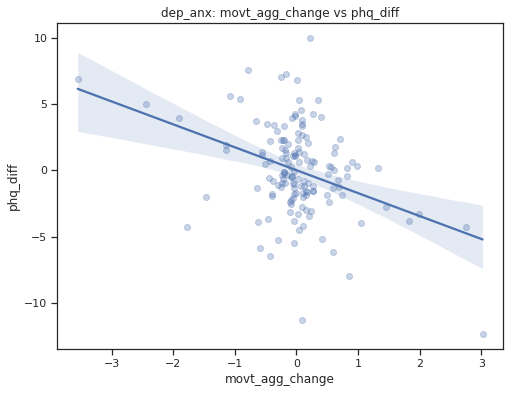

In [82]:
ls_utils.plot_cluster_scatter('movt_agg_change', 'phq_diff', phq_agg_df, 'dep_anx', (8,6))

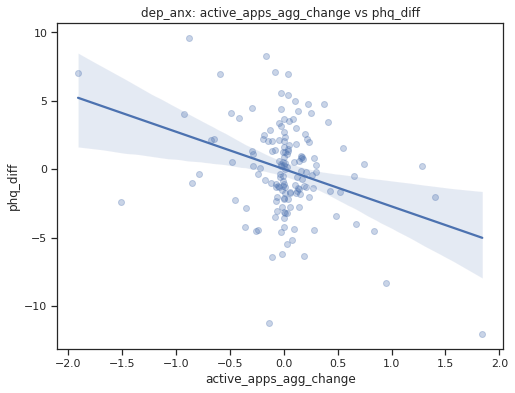

In [83]:
ls_utils.plot_cluster_scatter('active_apps_agg_change', 'phq_diff', phq_agg_df, 'dep_anx', (8,6))

In [166]:
phq_agg_df[agg_cols_change].isna().sum()

active_apps_agg_change     416
passive_apps_agg_change    416
social_apps_agg_change     416
fga_pca1_agg_change        416
fga_pca2_agg_change        416
fga_pca3_agg_change        416
fga_pca4_agg_change        416
fga_pca5_agg_change        416
sloc_pca1_agg_change       416
sloc_pca2_agg_change       416
sloc_pca3_agg_change       416
sloc_pca4_agg_change       416
sms_agg_change             432
cal_agg_change             423
fus_pca1_agg_change        469
fus_pca2_agg_change        469
fus_pca3_agg_change        469
dtype: int64

### Repeated Measures Correlation

In [167]:
pg.rm_corr(data=phq_agg_df, x='fus_pca1_agg_change', y='phq_diff', subject='pid')

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c

,r,dof,pval,CI95%,power
rm_corr,-0.128,576,0.002109,"[-0.21, -0.05]",0.869


In [168]:
sel_df = phq_agg_df[phq_agg_df['baseline_cluster'] == 'dep_anx']
#sel_df = sel_df.dropna(subset=['phq_diff', 'fus_pca1_agg_change'], axis='rows')
display(pg.rm_corr(data=sel_df, x='fus_pca1_agg_change', y='phq_diff', subject='pid'))
#pg.plot_rm_corr(data=sel_df, x='fus_pca1_agg_change', y='phq_diff', subject='pid')

,r,dof,pval,CI95%,power
rm_corr,-0.362,108,0.000101,"[-0.51, -0.19]",0.976


In [169]:
#sel_df = sel_df.dropna(subset=['phq_diff', 'fus_pca1_agg_change'], axis='rows')
display(pg.rm_corr(data=sel_df, x='active_apps_agg_change', y='phq_diff', subject='pid'))

,r,dof,pval,CI95%,power
rm_corr,-0.345,114,0.000147,"[-0.5, -0.17]",0.97


# Reverse PHQ

## Build reversed df

In [100]:
# load fus and circ data
rev_fus_daily = pd.read_pickle("wave1_features/fus_phq_start_0_14.df")
rev_circ_dict = pickle.load(open("wave1_features/circ_phq_start_0_14.dict", "rb"))

In [101]:
# correction for Series values in list, though it doesn't seem to have affected anything??
rev_new_dict = {}
for col, vals in rev_circ_dict.items():
    new_vals = []
    for v in vals:
        if isinstance(v, pd.Series):
            new_vals.append(v[0])
        else:
            new_vals.append(v)
    rev_new_dict[col] = new_vals
rev_circ_dict = rev_new_dict

### Calculate shifted change

In [102]:
%%time

sms_dict = ls_utils.build_col_dict(sms_cols, sms_daily, shift_df, 'phq_start', pre_days=0, post_days=14)
cal_dict = ls_utils.build_col_dict(cal_cols, cal_daily, shift_df, 'phq_start', pre_days=0, post_days=14)
fga_dict = ls_utils.build_col_dict(fga_cols, fga_daily, shift_df, 'phq_start', pre_days=0, post_days=14)
sloc_dict = ls_utils.build_col_dict(sloc_cols, sloc_daily, shift_df, 'phq_start', pre_days=0, post_days=14)

CPU times: user 50 s, sys: 63 ms, total: 50.1 s
Wall time: 50.1 s


In [103]:
rev_phq_df = shift_df.copy()

sensor_dicts = [sms_dict, cal_dict, fga_dict, sloc_dict, rev_circ_dict]
sensor_cols = sms_cols + cal_cols + fga_cols + sloc_cols + circ_cols

for sensor_dict in sensor_dicts:
    for col, vals in sensor_dict.items():
        rev_phq_df[col] = vals

# merge fused location       
rev_phq_df = rev_phq_df.merge(rev_fus_daily, how='left', on=['pid', 'study_wk'])
rev_phq_df = rev_phq_df.replace([np.inf, -np.inf], np.nan)

## Aggregate features

### fga

In [104]:
rev_phq_agg_df = rev_phq_df.copy()
rev_phq_agg_df[fga_cols] = (rev_phq_agg_df[fga_cols] - rev_phq_agg_df[fga_cols].mean()) / rev_phq_agg_df[fga_cols].std()
rev_phq_agg_df['active_apps_agg'] = rev_phq_agg_df[active_apps].mean(axis=1)
rev_phq_agg_df['passive_apps_agg'] = rev_phq_agg_df[passive_apps].mean(axis=1)
rev_phq_agg_df['social_apps_agg'] = rev_phq_agg_df[social_apps].mean(axis=1)

### sloc

In [105]:
rev_phq_agg_df[sloc_dur_cols] = (rev_phq_agg_df[sloc_dur_cols] - rev_phq_agg_df[sloc_dur_cols].mean()) / rev_phq_agg_df[sloc_dur_cols].std()
rev_phq_agg_df['work_dur_agg'] = rev_phq_agg_df[work_places]
rev_phq_agg_df['home_dur_agg'] = rev_phq_agg_df[home_places]
rev_phq_agg_df['religion_exercise_dur_agg'] = rev_phq_agg_df[religion_exercise_places].mean(axis=1)
rev_phq_agg_df['other_dur_agg'] = rev_phq_agg_df[other_places].mean(axis=1)
rev_phq_agg_df['social_place_dur_agg'] = rev_phq_agg_df[social_places].mean(axis=1)

### comm

In [106]:
rev_phq_agg_df[sms_cols] = (rev_phq_agg_df[sms_cols] - rev_phq_agg_df[sms_cols].mean()) / rev_phq_agg_df[sms_cols].std()
rev_phq_agg_df[cal_cols] = (rev_phq_agg_df[cal_cols] - rev_phq_agg_df[cal_cols].mean()) / rev_phq_agg_df[cal_cols].std()
rev_phq_agg_df['sms_agg'] = rev_phq_agg_df[sms_cols].mean(axis=1)
rev_phq_agg_df['cal_agg'] = rev_phq_agg_df[cal_cols].mean(axis=1)

### fus

In [107]:
rev_phq_agg_df[loc_cols] = (rev_phq_agg_df[loc_cols] - rev_phq_agg_df[loc_cols].mean()) / rev_phq_agg_df[loc_cols].std()
rev_phq_agg_df['movt_agg'] = rev_phq_agg_df[movt_cols].mean(axis=1)
rev_phq_agg_df['wkday_total_entropy_agg'] = rev_phq_agg_df[weekday_entropy].mean(axis=1)
rev_phq_agg_df['wkend_entropy_agg'] = rev_phq_agg_df[weekend_entropy].mean(axis=1)

## Shift columns

In [108]:
agg_cols = rev_phq_agg_df.columns[rev_phq_agg_df.columns.str.endswith("agg")]
agg_cols_shift = [s + '_shift' for s in agg_cols]
agg_cols_change = [s + '_change' for s in agg_cols]

In [109]:
rev_phq_agg_df[agg_cols_shift] = rev_phq_agg_df.groupby('pid')[agg_cols].shift(1)

In [110]:
for cur, prev, change in zip(agg_cols, agg_cols_shift, agg_cols_change):
    rev_phq_agg_df[change] = rev_phq_agg_df[cur] - rev_phq_agg_df[prev]

In [111]:
rev_phq_agg_df['phq_diff'].describe()

count    1025.000000
mean        0.008618
std         2.880980
min       -15.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max        16.000000
Name: phq_diff, dtype: float64

# Dump final aggregate DataFrames

In [112]:
agg_df.to_pickle("wave1_features/gad_spin_corr_unit.df")
rev_agg_df.to_pickle("wave1_features/rev_gad_spin_corr_unit.df")

In [113]:
phq_agg_df.to_pickle("wave1_features/phq_corr_unit.df")
rev_phq_agg_df.to_pickle("wave1_features/rev_phq_corr_unit.df")

In [114]:
agg_cols_change

['active_apps_agg_change',
 'passive_apps_agg_change',
 'social_apps_agg_change',
 'work_dur_agg_change',
 'home_dur_agg_change',
 'religion_exercise_dur_agg_change',
 'other_dur_agg_change',
 'social_place_dur_agg_change',
 'sms_agg_change',
 'cal_agg_change',
 'movt_agg_change',
 'wkday_total_entropy_agg_change',
 'wkend_entropy_agg_change']

In [115]:
groups

NameError: name 'groups' is not defined